In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import train
import preprocessing
import test

import pandas as pd
from sodapy import Socrata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams.update({'font.size': 12})

## Load and prepare the data


In [2]:
#Run to get new call data
client = Socrata("data.seattle.gov", None)

# Returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("kzjm-xkqj", limit = 1000000)


# Convert query results to pandas DataFrame
df = pd.DataFrame.from_records(results)
df = df.iloc[:,:7]
df = preprocessing.add_time_features(df)


# Run to get new weather data
from wwo_hist import retrieve_hist_data
frequency = 1
start_date = df.date.iloc[-1].strftime("%d-%b-%Y")
end_date = df.date.iloc[0].strftime("%d-%b-%Y")
api_key = '2d65942715e14539bbc163119222808'
location_list = ['seattle']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = False,
                                store_df = True)



Retrieving weather data for seattle


Currently retrieving data for seattle: from 2012-08-19 to 2012-08-31
Time elapsed (hh:mm:ss.ms) 0:00:00.479316
Currently retrieving data for seattle: from 2012-09-01 to 2012-09-30
Time elapsed (hh:mm:ss.ms) 0:00:01.082510
Currently retrieving data for seattle: from 2012-10-01 to 2012-10-31
Time elapsed (hh:mm:ss.ms) 0:00:01.709674
Currently retrieving data for seattle: from 2012-11-01 to 2012-11-30
Time elapsed (hh:mm:ss.ms) 0:00:02.354066
Currently retrieving data for seattle: from 2012-12-01 to 2012-12-31
Time elapsed (hh:mm:ss.ms) 0:00:03.002946
Currently retrieving data for seattle: from 2013-01-01 to 2013-01-31
Time elapsed (hh:mm:ss.ms) 0:00:03.625580
Currently retrieving data for seattle: from 2013-02-01 to 2013-02-28
Time elapsed (hh:mm:ss.ms) 0:00:04.173264
Currently retrieving data for seattle: from 2013-03-01 to 2013-03-31
Time elapsed (hh:mm:ss.ms) 0:00:04.771935
Currently retrieving data for seattle: from 2013-04-01 to 2013-04-30
Tim

Time elapsed (hh:mm:ss.ms) 0:00:49.737441
Currently retrieving data for seattle: from 2018-10-01 to 2018-10-31
Time elapsed (hh:mm:ss.ms) 0:00:50.459760
Currently retrieving data for seattle: from 2018-11-01 to 2018-11-30
Time elapsed (hh:mm:ss.ms) 0:00:51.281960
Currently retrieving data for seattle: from 2018-12-01 to 2018-12-31
Time elapsed (hh:mm:ss.ms) 0:00:51.923149
Currently retrieving data for seattle: from 2019-01-01 to 2019-01-31
Time elapsed (hh:mm:ss.ms) 0:00:52.689161
Currently retrieving data for seattle: from 2019-02-01 to 2019-02-28
Time elapsed (hh:mm:ss.ms) 0:00:53.293132
Currently retrieving data for seattle: from 2019-03-01 to 2019-03-31
Time elapsed (hh:mm:ss.ms) 0:00:53.945261
Currently retrieving data for seattle: from 2019-04-01 to 2019-04-30
Time elapsed (hh:mm:ss.ms) 0:00:54.570563
Currently retrieving data for seattle: from 2019-05-01 to 2019-05-31
Time elapsed (hh:mm:ss.ms) 0:00:55.236123
Currently retrieving data for seattle: from 2019-06-01 to 2019-06-30
T

In [3]:
weather = hist_weather_data[0]
weather = weather.rename({'date_time': 'datetime'}, axis=1)
weather = weather[['datetime','tempC','visibility','windspeedKmph','totalSnow_cm']]
weather[['tempC','visibility','windspeedKmph','totalSnow_cm']] = weather[['tempC','visibility','windspeedKmph','totalSnow_cm']].astype('float')
weather = preprocessing.add_time_features(weather)
weather['date'] = pd.to_datetime(weather[['year','month','day','hour']]).apply(lambda x: x.ctime())
weather = weather.set_index('date')
weather.head(5)

,datetime,tempC,visibility,windspeedKmph,totalSnow_cm,year,month,dayofweek,hour,day
date,,,,,,,,,,
Sun Aug 19 00:00:00 2012,2012-08-19 00:00:00,15.0,2.0,8.0,0.0,2012,8,6,0,19
Sun Aug 19 01:00:00 2012,2012-08-19 01:00:00,15.0,2.0,7.0,0.0,2012,8,6,1,19
Sun Aug 19 02:00:00 2012,2012-08-19 02:00:00,14.0,2.0,6.0,0.0,2012,8,6,2,19
Sun Aug 19 03:00:00 2012,2012-08-19 03:00:00,14.0,2.0,6.0,0.0,2012,8,6,3,19
Sun Aug 19 04:00:00 2012,2012-08-19 04:00:00,15.0,5.0,6.0,0.0,2012,8,6,4,19


In [4]:
grouped_df = preprocessing.group_df_func(df, ['year', 'month', 'day','hour'], date_col = True)
grouped_df = grouped_df.set_index('date')
for i in range(8):
    grouped_df['num_calls_prev'+str(i+1)] = grouped_df.num_calls.shift(i+1)
grouped_df = pd.concat([grouped_df, weather[['tempC','windspeedKmph']]], axis = 1)
grouped_df = grouped_df.dropna(axis=0)
grouped_df = grouped_df.iloc[-24*30*18:] ## keeping hourly calls data for the last 18 months
# grouped_df.head()

### Dummy variables


In [5]:
dummy_fields = ['year', 'month', 'day','hour']
for each in dummy_fields:
    dummies = pd.get_dummies(grouped_df[each], prefix=each, drop_first=False)
    grouped_df = pd.concat([grouped_df, dummies], axis=1)

fields_to_drop = ['year','month','day','hour']
data = grouped_df.drop(fields_to_drop, axis=1)
data = data.reset_index(drop=True)
data.head()

,num_calls,num_calls_prev1,num_calls_prev2,num_calls_prev3,num_calls_prev4,num_calls_prev5,num_calls_prev6,num_calls_prev7,num_calls_prev8,tempC,...,hour_14.0,hour_15.0,hour_16.0,hour_17.0,hour_18.0,hour_19.0,hour_20.0,hour_21.0,hour_22.0,hour_23.0
0,12.0,11.0,9.0,12.0,12.0,12.0,16.0,10.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,7.0,12.0,11.0,9.0,12.0,12.0,12.0,16.0,10.0,3.0,...,0,0,0,0,0,0,0,0,0,0
2,5.0,7.0,12.0,11.0,9.0,12.0,12.0,12.0,16.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,9.0,5.0,7.0,12.0,11.0,9.0,12.0,12.0,12.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,9.0,9.0,5.0,7.0,12.0,11.0,9.0,12.0,12.0,1.0,...,0,0,0,0,0,0,0,0,0,0


### Scaling target variables
To make training the network easier, I standardized each of the continuous variables. 

The scaling factors are saved so I can go backwards when I use the network for predictions.

In [6]:
# Saving data for approximately the last 28 days 
test_data = data[-24*28:]

# Now removing the test data from the data set 
data = data[:-24*28]

# quant_features = ['tempC','windspeedKmph','num_calls']
quant_features = ['num_calls','num_calls_prev1','num_calls_prev2','num_calls_prev3',
                  'num_calls_prev4','num_calls_prev5','tempC','windspeedKmph']

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
    test_data.loc[:, each] = (test_data[each] - mean)/std

### Splitting the data into training, testing, and validation sets


In [7]:
# Separate the data into features and targets
target_fields = ['num_calls']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

###### Training and validation set

In [8]:
# Hold out the last 14 days or so of the remaining data as a validation set
train_features, train_targets = features[:-24*14], targets[:-24*14]
val_features, val_targets = features[-24*14:], targets[-24*14:]

In [9]:
from my_answers import NeuralNetwork

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [11]:
import sys
from my_answers import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['num_calls']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(np.array(network.run(train_features)).T, train_targets['num_calls'].values)
    val_loss = MSE(np.array(network.run(val_features)).T, val_targets['num_calls'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.624 ... Validation loss: 0.749

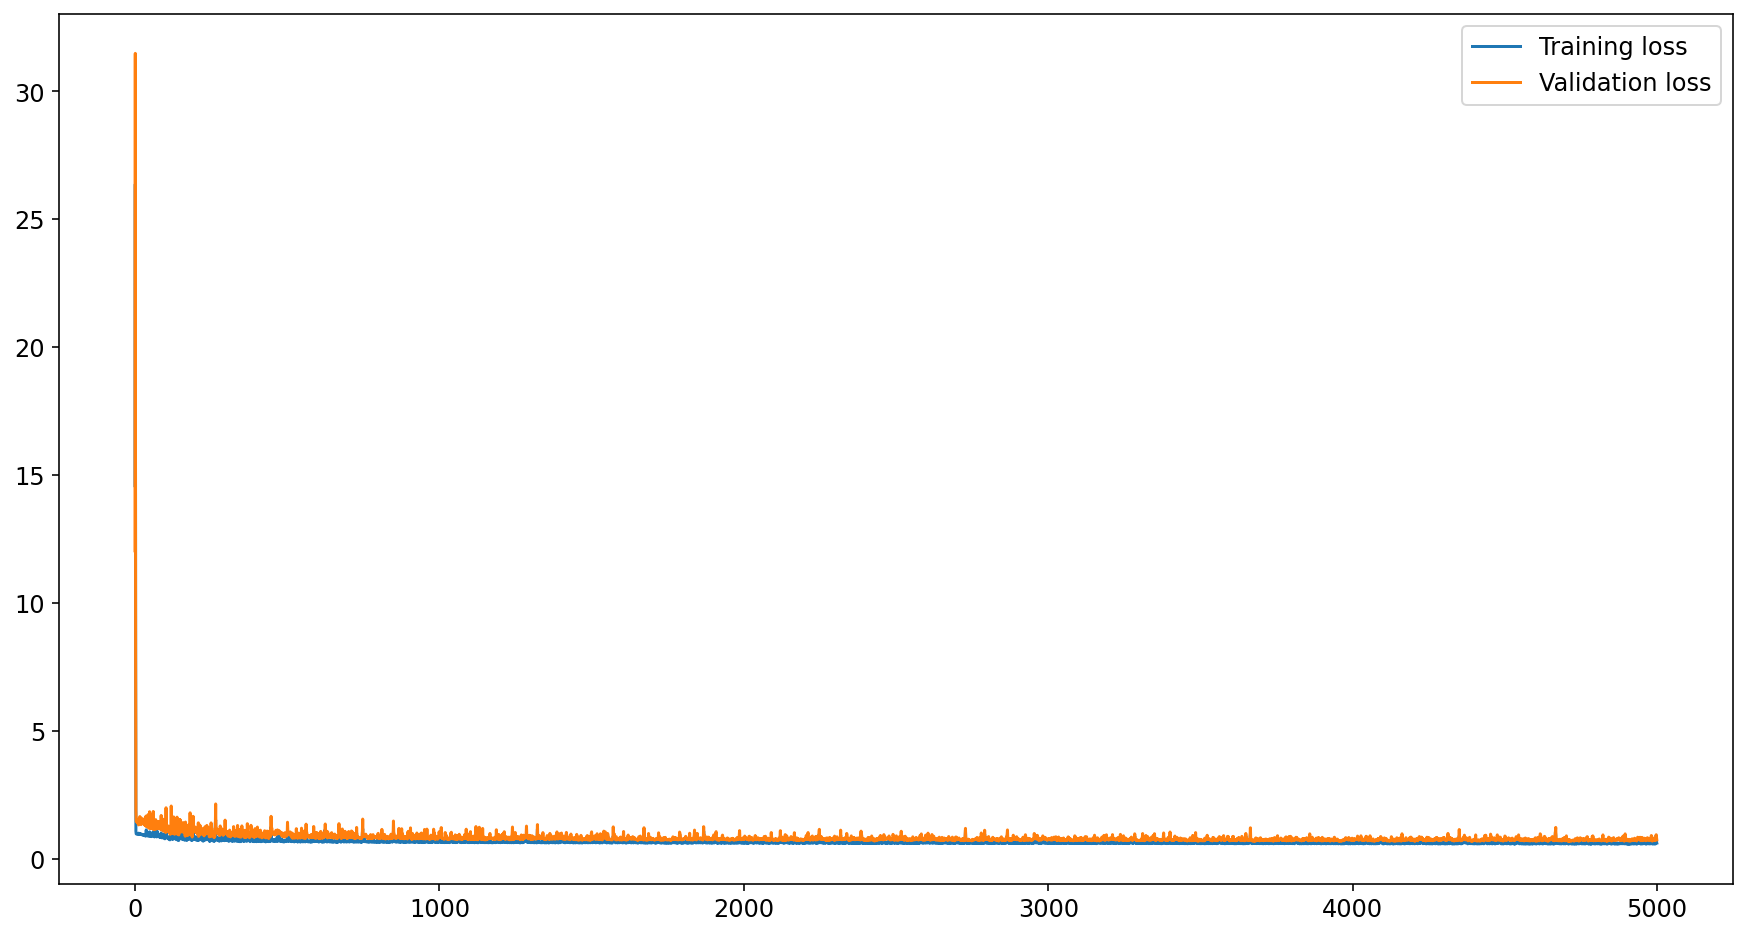

In [12]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Checking the predictions


The mean squared error is: 18.42304892885821
The mean absolute error is: 3.6180358004661906


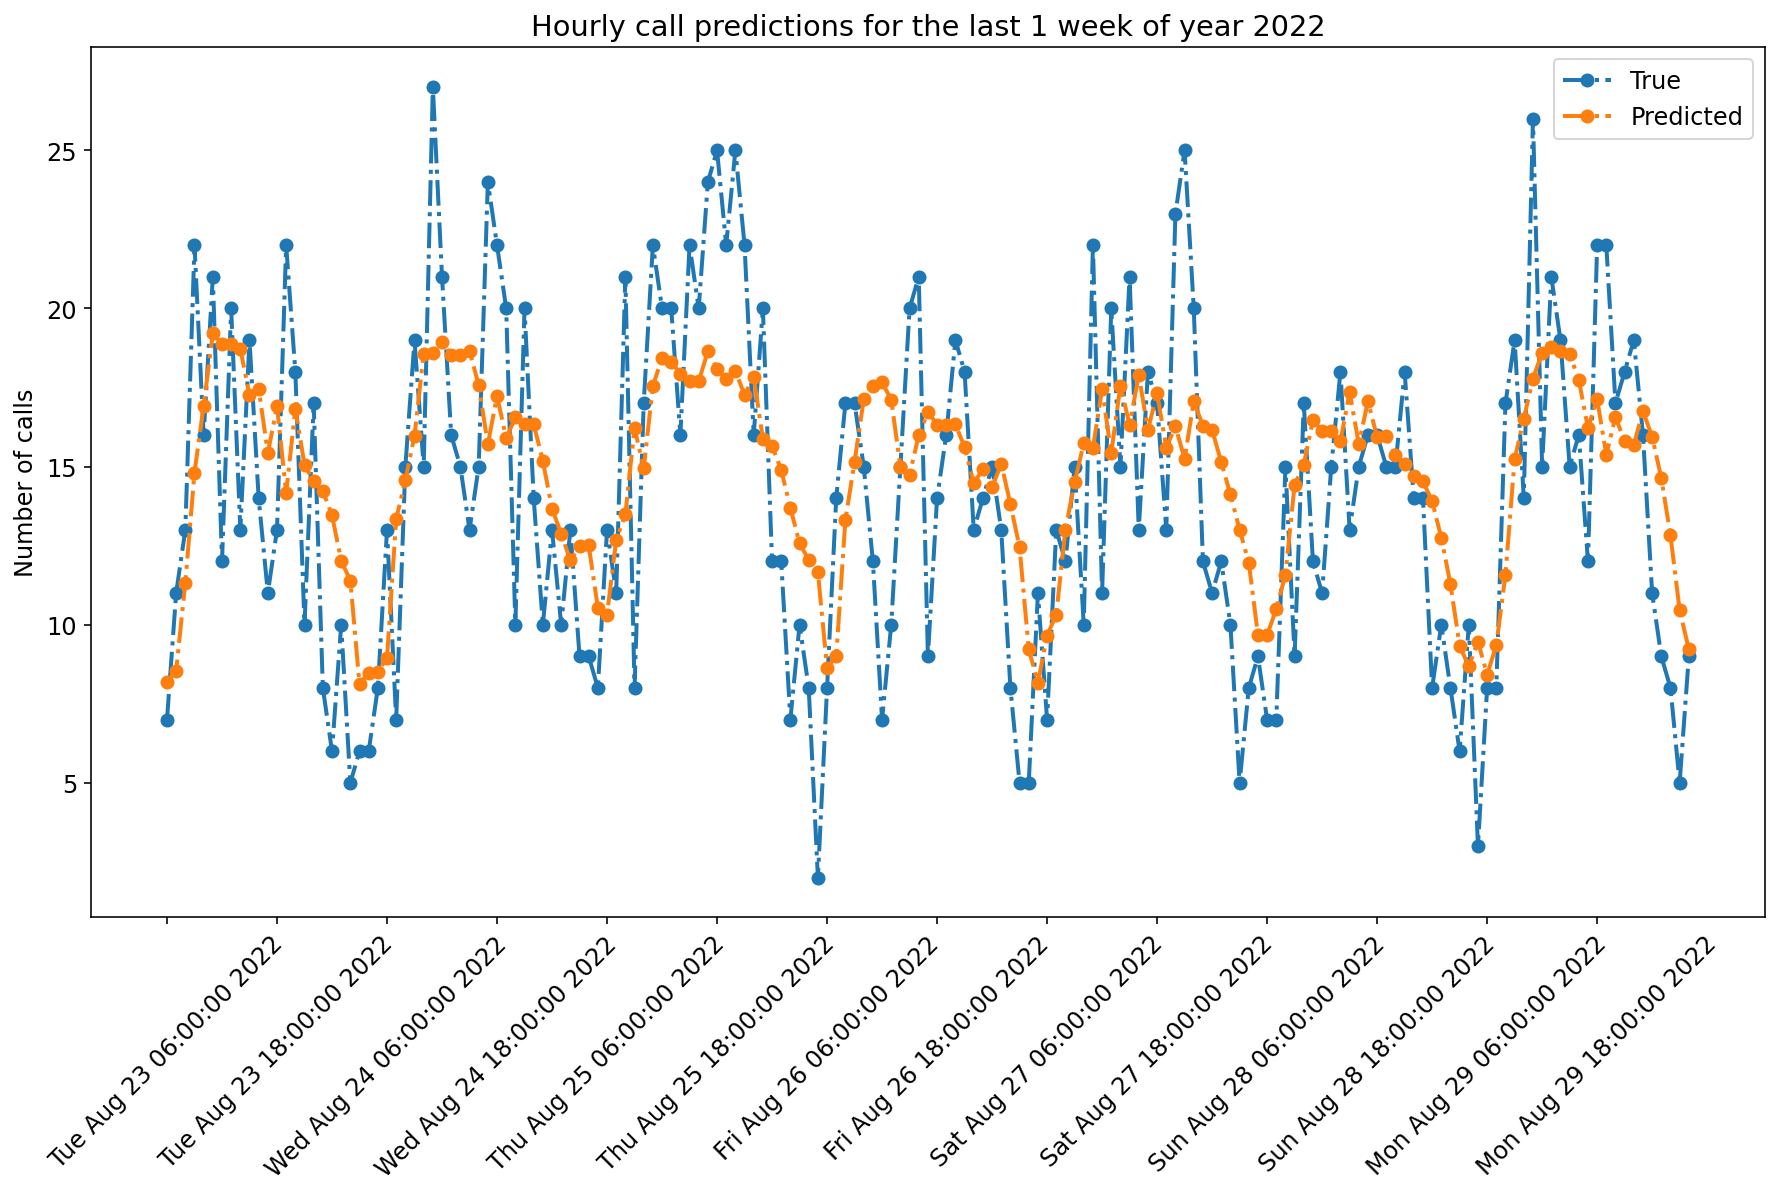

In [13]:
mean, std = scaled_features['num_calls']
predictions = np.array(network.run(test_features.iloc[-24*7:])).T*std + mean
results_df = test.convert_results_dataframe(test_targets['num_calls'].iloc[-24*7:]*std + mean, 
                                            predictions[0], grouped_df.reset_index(drop=True).iloc[-24*7:], 'hourly')

results_df = test.evaluate_predictions(results_df, 24*7, 'hourly', 'Hourly call predictions for the last 1 week of year 2022')